In [1]:
import pickle
import librosa
import numpy as np
import librosa.display
from constants import *
import IPython.display as ipd
import matplotlib.pyplot as plt
from pathlib import Path, PurePath

In [2]:
ney_wav_files = sorted(
    [NEY_WAV_DIR + f.name for f in Path(NEY_WAV_DIR).rglob("*.wav")])
gtr_wav_files = sorted(
    [GTR_WAV_DIR + f.name for f in Path(GTR_WAV_DIR).rglob("*.wav")])

In [3]:
def preprocess_wav_file(file_path):
    """
    Takes a wav file path as arg and splits into chunks of WINDOW_SAMPLE_LEN
    with overlap of WINDOW_SLIDE_MARGIN.
    """
    signal, _ = librosa.load(file_path, mono=True, sr=SR)
    signal_len = len(signal)
    result = {
        "file_path": file_path,
        "chunks": []
    }
    i = 0
    while True:
        # determine the start & end positions with overlap for cross-fade
        # [0:100], [90:190], [180:280], ...
        start = i * WINDOW_SAMPLE_LEN - i * WINDOW_SLIDE_MARGIN
        end = start + WINDOW_SAMPLE_LEN
        if end >= signal_len:
            break

        window = signal[start: end]
        stft = librosa.stft(window, n_fft=N_FFT, hop_length=HOP)[:-1]
        # extract abs and angle
        abs_part = np.abs(stft)
        angle_part = np.angle(stft)
        real_part = np.real(stft)
        imag_part = np.imag(stft)
        result["chunks"].append({
            "start": start,
            "end": end,
            "abs": abs_part,
            "angle": angle_part,
            "real": real_part,
            "imag": imag_part,
            "signal": window
        })
        i += 1

    return result

In [4]:
result = preprocess_wav_file("dataset/ney/00_Ney_C_3.wav")
print(len(result["chunks"]))
print(result["chunks"][0]["abs"].shape)
print(result["chunks"][0]["angle"].shape)
print(result["chunks"][0]["real"].shape)
print(result["chunks"][0]["imag"].shape)
print(result["chunks"][0]["signal"].shape)

21
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(16320,)


In [5]:
def save_preprocessed_dataset(file_list, target_dir):
    """
    Processes all wav files in file_list arg.
    Saves the preprocessed files in respective directories
    """
    min_max = {
        "min": {
            "abs": np.inf,
            "angle": np.inf,
            "real": np.inf,
            "imag": np.inf,
            "signal": np.inf
        },
        "max": {
            "abs": -np.inf,
            "angle": -np.inf,
            "real": -np.inf,
            "imag": -np.inf,
            "signal": -np.inf
        }
    }
    for file_path in file_list:
        result = preprocess_wav_file(file_path)
        file_stem = Path(result["file_path"]).stem
        new_dir_path = PurePath(target_dir, file_stem)
        p = Path(new_dir_path)
        p.mkdir(parents=True, exist_ok=True)
        i = 0
        for chunk in result["chunks"]:
            chunk_name = f"chunk_{i}"
            min_abs, max_abs = np.min(chunk["abs"]), np.max(chunk["abs"])
            min_ang, max_ang = np.min(chunk["angle"]), np.max(chunk["angle"])
            min_real, max_real = np.min(chunk["real"]), np.max(chunk["real"])
            min_imag, max_imag = np.min(chunk["imag"]), np.max(chunk["imag"])
            min_sig, max_sig = np.min(chunk["signal"]), np.max(chunk["signal"])

            if min_abs < min_max["min"]["abs"]:
                min_max["min"]["abs"] = min_abs
            if max_abs > min_max["max"]["abs"]:
                min_max["max"]["abs"] = max_abs

            if min_ang < min_max["min"]["angle"]:
                min_max["min"]["angle"] = min_ang
            if max_ang > min_max["max"]["angle"]:
                min_max["max"]["angle"] = max_ang

            if min_real < min_max["min"]["real"]:
                min_max["min"]["real"] = min_real
            if max_real > min_max["max"]["real"]:
                min_max["max"]["real"] = max_real

            if min_imag < min_max["min"]["imag"]:
                min_max["min"]["imag"] = min_imag
            if max_imag > min_max["max"]["imag"]:
                min_max["max"]["imag"] = max_imag
            
            if min_sig < min_max["min"]["signal"]:
                min_max["min"]["signal"] = min_sig
            if max_sig > min_max["max"]["signal"]:
                min_max["max"]["signal"] = max_sig

            chunk_path = PurePath(new_dir_path, chunk_name)
            with open(chunk_path, "wb") as handle:
                pickle.dump(chunk, handle)
            i += 1
            
    return min_max

In [6]:
min_max_ney = save_preprocessed_dataset(ney_wav_files, NEY_FEATURE_DIR)
min_max_gtr = save_preprocessed_dataset(gtr_wav_files, GTR_FEATURE_DIR)

In [7]:
min_max = {
    "ney": min_max_ney,
    "gtr": min_max_gtr
}

with open("dataset/features/min_max.pkl", "wb") as handle:
    pickle.dump(min_max, handle)

In [8]:
with open("dataset/features/min_max.pkl", "rb") as handle:
    min_max = pickle.load(handle)

min_max

{'ney': {'min': {'abs': 1.6169622e-07,
   'angle': -3.1415923,
   'real': -103.57541,
   'imag': -101.308266,
   'signal': -0.8600464},
  'max': {'abs': 104.15079,
   'angle': 3.1415925,
   'real': 92.45073,
   'imag': 97.06866,
   'signal': 0.9161682}},
 'gtr': {'min': {'abs': 1.5412273e-07,
   'angle': -3.141592,
   'real': -89.06632,
   'imag': -95.478455,
   'signal': -0.73135376},
  'max': {'abs': 96.51824,
   'angle': 3.1415925,
   'real': 96.095795,
   'imag': 90.098434,
   'signal': 0.9884949}}}

Test audio restoration from STFT chunks


In [9]:
def restore_wave_chunks(dir_path, by="polar"):
    """ 
    Fetches all chunk dumps in given directory.
    Returns all wave chunks as list
    """
    stft_waves = []
    file_paths = sorted(list(Path(dir_path).iterdir()),
                        key=lambda x: int(x.stem.split("_")[1]))
    for file_path in file_paths:
        with open(file_path, "rb") as handle:
            chunk = pickle.load(handle)
            if by == "polar":
                abs_part = chunk["abs"]
                angle_part = chunk["angle"]
                stft = abs_part * (np.cos(angle_part) + 1j*np.sin(angle_part))
            elif by == "cartesian":
                real_part = chunk["real"]
                imag_part = chunk["imag"]
                stft = real_part + 1j*imag_part
            wave = librosa.istft(stft, n_fft=N_FFT, hop_length=HOP)
            stft_waves.append(wave)
    return stft_waves

In [11]:
def stitch_wave_chunks(waves):
    """ 
    Takes wave chunks as a list and stitches them with cross-fades.
    """
    stitched_wave = np.array([])
    fade_in = np.linspace(0, 1, WINDOW_SLIDE_MARGIN)
    fade_out = np.linspace(1, 0, WINDOW_SLIDE_MARGIN)

    for i, wave in enumerate(waves):
        if i > 0:
            # fade in wave chunks after the 1st one
            wave[:WINDOW_SLIDE_MARGIN] *= fade_in
        # fade out all wave chunks
        wave[-WINDOW_SLIDE_MARGIN:] *= fade_out

        if len(stitched_wave) > 0:
            stitched_wave[-WINDOW_SLIDE_MARGIN:] += wave[:WINDOW_SLIDE_MARGIN]
            stitched_wave = np.append(
                stitched_wave, wave[WINDOW_SLIDE_MARGIN:])
        else:
            stitched_wave = np.append(stitched_wave, wave)

    return stitched_wave

Original signal len: 102000
STFT signal len: 98240


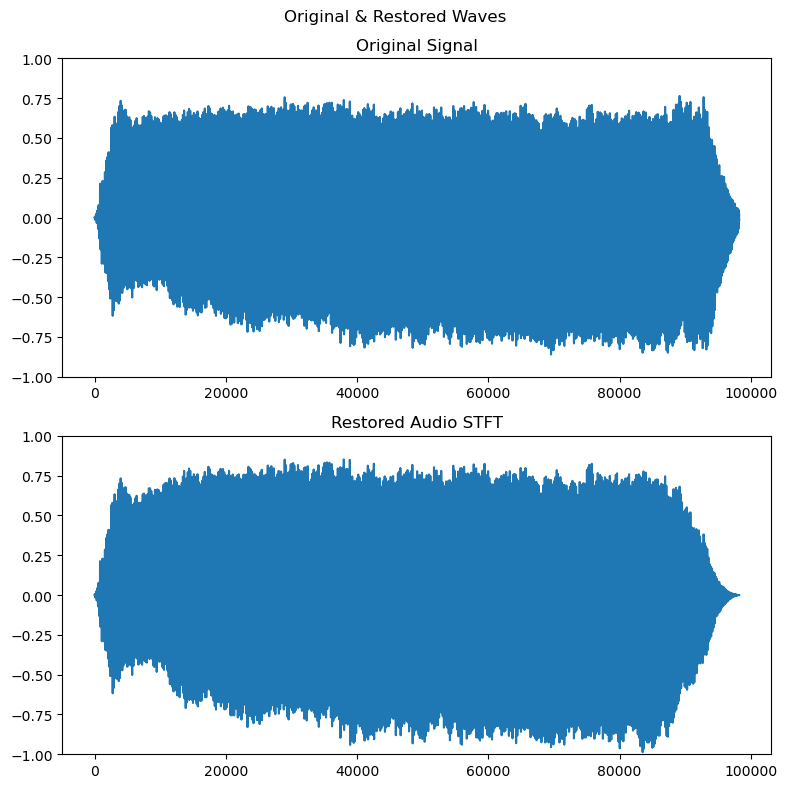

In [12]:
signal, _ = librosa.load("dataset/ney/00_Ney_C_3.wav", mono=True, sr=SR)
stft_waves = restore_wave_chunks("dataset/features/ney/00_Ney_C_3/", by="cartesian")
stitched_stft_wave = stitch_wave_chunks(stft_waves)

fig, axs = plt.subplots(2, figsize=(8, 8))
fig.suptitle("Original & Restored Waves")
axs[0].set_title("Original Signal")
axs[0].set_ylim([-1, 1])
axs[0].plot(signal[:len(stitched_stft_wave)])
print(f"Original signal len: {len(signal)}")
axs[1].set_title("Restored Audio STFT")
axs[1].set_ylim([-1, 1])
axs[1].plot(stitched_stft_wave)
print(f"STFT signal len: {len(stitched_stft_wave)}")
fig.tight_layout()
plt.show()

In [13]:
ipd.Audio(signal, rate=SR)

In [14]:
ipd.Audio(stitched_stft_wave, rate=SR)